# Model Optimization and Nonlinear Models

CSC/DSC 340 Week 5 Slides

Author: [Dr. Julie Butler](www.juliebutler.org)

Date Created: August 19, 2023

Last Modified: August 19, 2023

## Plan for the Week

**Monday**

Week 5 Pre-Class Homework and Week 4 In-Class Assignment Due

Lecture: Model Optimization and Nonlinear Models

**Tuesday**

Office Hours: 4pm - 6pm

**Wednesday**

Finish Lecture: Model Optimization and Nonlinear Models

Start Week 5 In-Class Assignment

Week 4 Post-Class Homework Due

**Thursday**

Office Hours: 11am - 1pm

**Friday**

In-Class Assignment Week 5

## Part 1: Hyperparameter Tuning

## Why do we need hyperparameter tuning?
* The values of the hyperparameters change the output of the model
* Bad hyperparameters lead to bad results

In [1]:
##############################
##         IMPORTS          ##
##############################
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.datasets import fetch_california_housing

ModuleNotFoundError: No module named 'sklearn'

* New data set: California Housing
    * Goal: Predict the price a house will sale for (house price/100k) given information about the house
    * In-Class Week 5

In [2]:
# Print the features
fetch_california_housing().feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [3]:
##############################
##        IMPORT DATA       ##
##############################
X, y = fetch_california_housing(return_X_y = True)

In [4]:
##############################
##        SCALE DATA        ##
##############################
scaler = StandardScaler()
scaler.fit(X)
Z = scaler.transform(X)

In [5]:
##############################
##     TRAIN-TEST SPLIT     ##
##############################
X_train, X_test, y_train, y_test = train_test_split(Z,y,test_size=0.2)

MSE: 0.5092222700374358


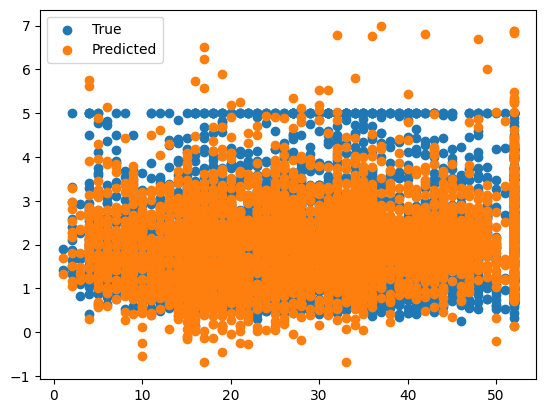

In [6]:
##############################
##        GOOD ALPHA        ##
##############################
ridge = Ridge(alpha=1e-15)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')
plt.legend()

MSE: 1.3243939059095313


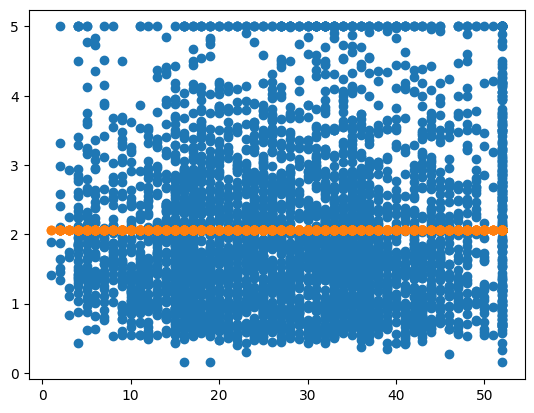

In [7]:
##############################
##        BAD ALPHA         ##
##############################
ridge = Ridge(alpha=1e15)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')

## Methods for Hyperparameter Tuning

## Using Default Values
* Scikit-Learn sets the default value of $\alpha$ for ridge regression to 1.0, which is a reasonable high level of regularization

In [8]:
# Make the data set smaller (20k+ points in total)
# More points = more data to generate patterns BUT more run time
X = X[:1000]
y = y[:1000]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [9]:
%%time
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

CPU times: total: 0 ns
Wall time: 1e+03 µs


MSE: 0.21051424465105423


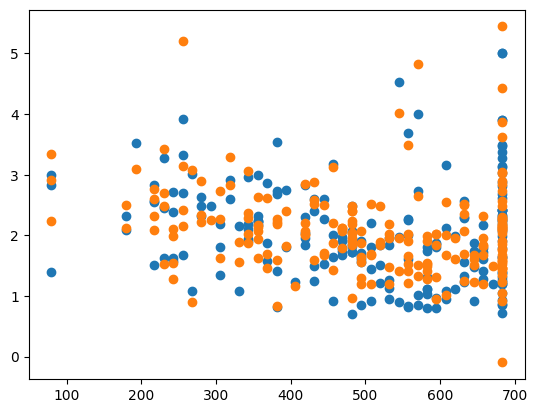

In [10]:
err = MSE(y_pred, y_test)
print("MSE:", err)

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')

### Pros
* Fast and no need to modify the algorithm

### Cons
* Default value may not be the best value, but no test are done to check

## For Loop Tuning

* Use a for loop to check many different values for the hyperparameters
* Can use nested for loops if more than one hyperparamter

In [11]:
%%time
best_err = 1e4
best_alpha = None
for alpha in np.logspace(-15,4,1000):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    
    err = MSE(y_pred, y_test)
    
    if err < best_err:
        best_err = err
        best_alpha = alpha

CPU times: total: 625 ms
Wall time: 628 ms


MSE: 0.2070867887631969
CHOSEN ALPHA: 3.6104185971733447


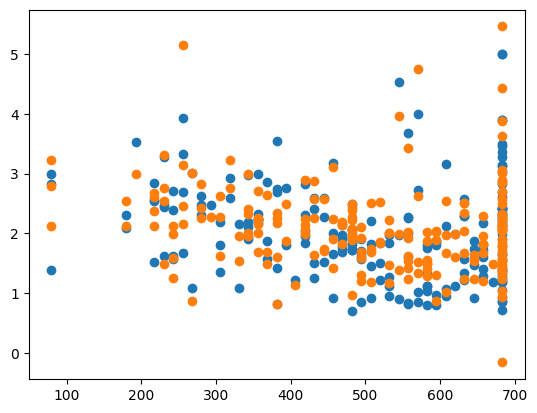

In [12]:
ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)
print("CHOSEN ALPHA:", best_alpha)

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')

### Pros
* Checks more than one value to find the best value
* Simple concept
* Short(ish) run times

### Cons
* Long piece of code
* Not checking all possible values of the hyperparameters

## GridSearchCV (Scikit-Learn)

* Scikit-Learn has several hyperparameter tuning implementation
* Grid search is a brute force algorithm which checks as many values as given 
    * If more than one hyperparameter, it checks every single possible combination
* "Same" test as for loops but gives much more information, but also takes longer

In [13]:
%%time
from sklearn.model_selection import GridSearchCV

parameters = {'alpha':np.logspace(-15,4,5000)}

ridge = Ridge()

grid_search = GridSearchCV(ridge, parameters,\
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'alpha': 0.28966256925535433}
CPU times: total: 20 s
Wall time: 20 s


MSE: 0.2167862778568034
CHOSEN ALPHA: 0.28966256925535433


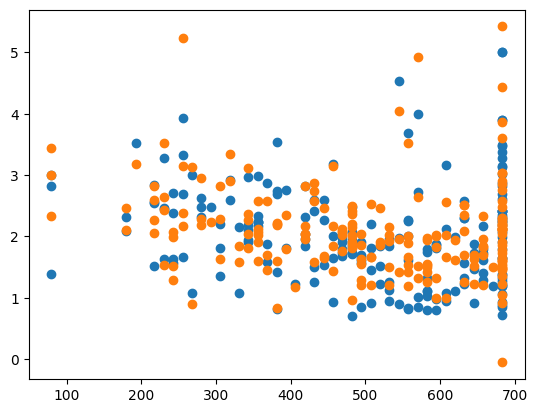

In [14]:
ridge = Ridge(alpha=grid_search.best_params_['alpha'])
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)
print('CHOSEN ALPHA:', grid_search.best_params_['alpha'])

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')

### Pros
* Only takes a few lines to implement
* Gives a lot of data once it is fit

### Cons
* Long run times
* Only searches the range of parameters given

## RandomizedSearchCV (Scikit-Learn)

* Tries `n_iter` randomly chosen values for the hyperparmeters taken from a given distribution (uniform in this case)

In [15]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

distributions = {'alpha':uniform(loc=0, scale=4)}

ridge = Ridge()

random_search = RandomizedSearchCV(ridge, distributions,\
                                   scoring='neg_mean_squared_error', n_iter=5000)
random_search.fit(X_train, y_train)

print(random_search.best_params_, random_search.best_score_)

{'alpha': 0.2894503404237785} -0.32083916467421225
CPU times: total: 20 s
Wall time: 20 s


MSE: 0.21678949380155416
CHOSEN ALPHA: 0.2894503404237785


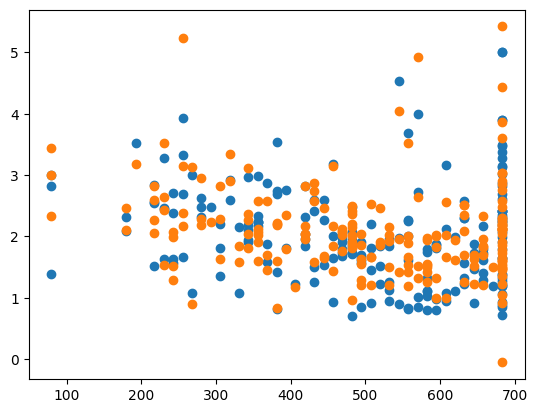

In [16]:
ridge = Ridge(alpha=random_search.best_params_['alpha'])
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)
print('CHOSEN ALPHA:', random_search.best_params_['alpha'])

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')

### Pros
* Only takes a few lines to implement
* Gives a lot of data once it is fit

### Cons
* Long run times (depending on value of `n_iter`)
* Only searches a finite number of parameter combinations

## Bayesian Ridge Regression

* Finds the "most likely" value for $\alpha$ using Bayesian stastics
* Leaves no uncertainity that the best value was just not sampled

In [17]:
%%time
from sklearn.linear_model import BayesianRidge

bayesian_ridge = BayesianRidge()
bayesian_ridge.fit(X_train, y_train)
y_pred = bayesian_ridge.predict(X_test)

print(bayesian_ridge.alpha_)

3.2662073961103295
CPU times: total: 0 ns
Wall time: 3 ms


MSE: 0.21495950326574317
CHOSEN ALPHA: 3.2662073961103295


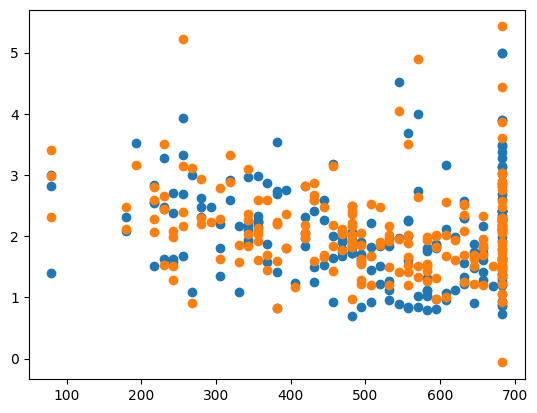

In [18]:
ridge = BayesianRidge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

err = MSE(y_pred, y_test)
print("MSE:", err)
print('CHOSEN ALPHA:', ridge.alpha_)

X_test_plot = scaler.inverse_transform(X_test)

plt.scatter(X_test_plot[:,1],y_test,label='True')
plt.scatter(X_test_plot[:,1],y_pred,label='Predicted')

### Pros
* Only takes a few lines to implement
* Statical certainity that the given $\alpha$ value is the best value
* Short run times

### Cons
* Only valid for Bayesian ridge regression (linear model)

## Comparison of $\alpha$, Accuracy, and Run Time
* Exact values depend on the train-test split and RandomizedSearch results; these values were taken from one run

In [19]:
labels = ['default', 'for loops', 'GridSearchCV', 'RandomizedSearchCV', 'Bayesian']
alphas = [1.0, 1e-15, 769.79, 3.99, 1.90]
mse = [0.522, 0.522, 0.544, 0.522, 0.522]
run_times = [20.8/1000, 1.35, 57.7, 7*60+40, 1.18] #ms

Text(0.5, 0, 'Hyperparameter Tuning Method')

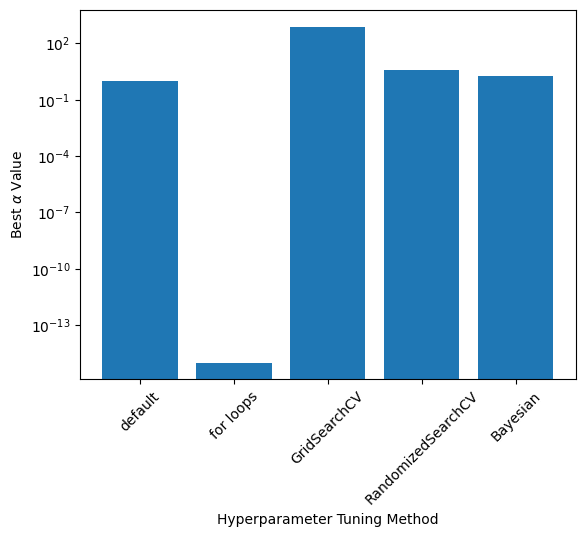

In [20]:
plt.bar(np.arange(0,len(labels)), alphas)
plt.yscale('log')
plt.xticks(np.arange(0,len(labels)), labels, rotation=45)
plt.ylabel(r"Best $\alpha$ Value")
plt.xlabel("Hyperparameter Tuning Method")

Text(0.5, 0, 'Hyperparameter Tuning Method')

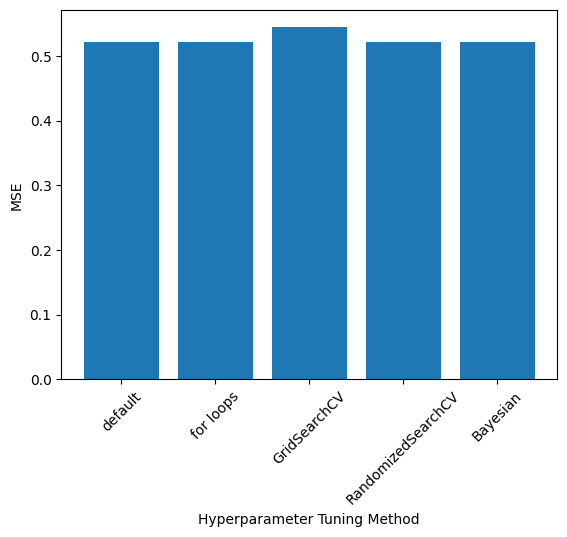

In [21]:
plt.bar(np.arange(0,len(labels)), mse)
plt.xticks(np.arange(0,len(labels)), labels, rotation=45)
plt.ylabel(r"MSE")
plt.xlabel("Hyperparameter Tuning Method")

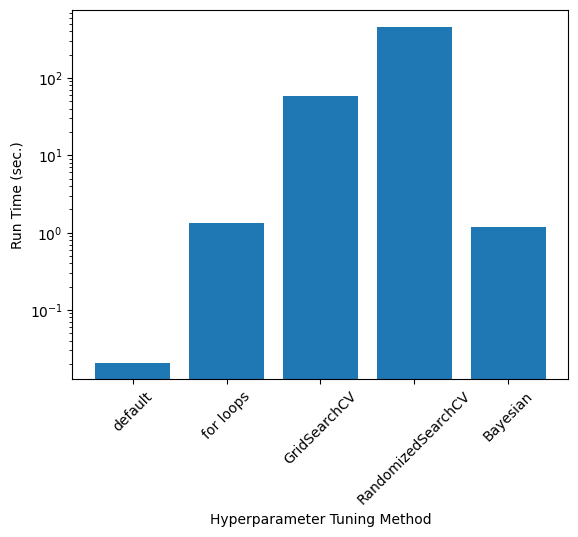

In [22]:
plt.bar(np.arange(0,len(labels)), run_times)
plt.xticks(np.arange(0,len(labels)), labels, rotation=45)
plt.ylabel(r"Run Time (sec.)")
plt.xlabel("Hyperparameter Tuning Method")
plt.yscale('log')

## Part 2: Feature Engineering

Feature engineering is the process of eliminating or altering given inputs in order to improve the model's predictions
* Design matrix/alter the inputs
* Remove features that are not useful
* Scaling the features or targets

In [23]:
import pandas as pd
import seaborn as sns

housing = fetch_california_housing()

housing_data = pd.DataFrame(housing.data, columns=housing.feature_names)

housing_data['target'] = housing.target

housing_data = housing_data.sample(1000)

Pairplots can give us initial ideas about the data set and and obvious relations

C:\Users\butlerju\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


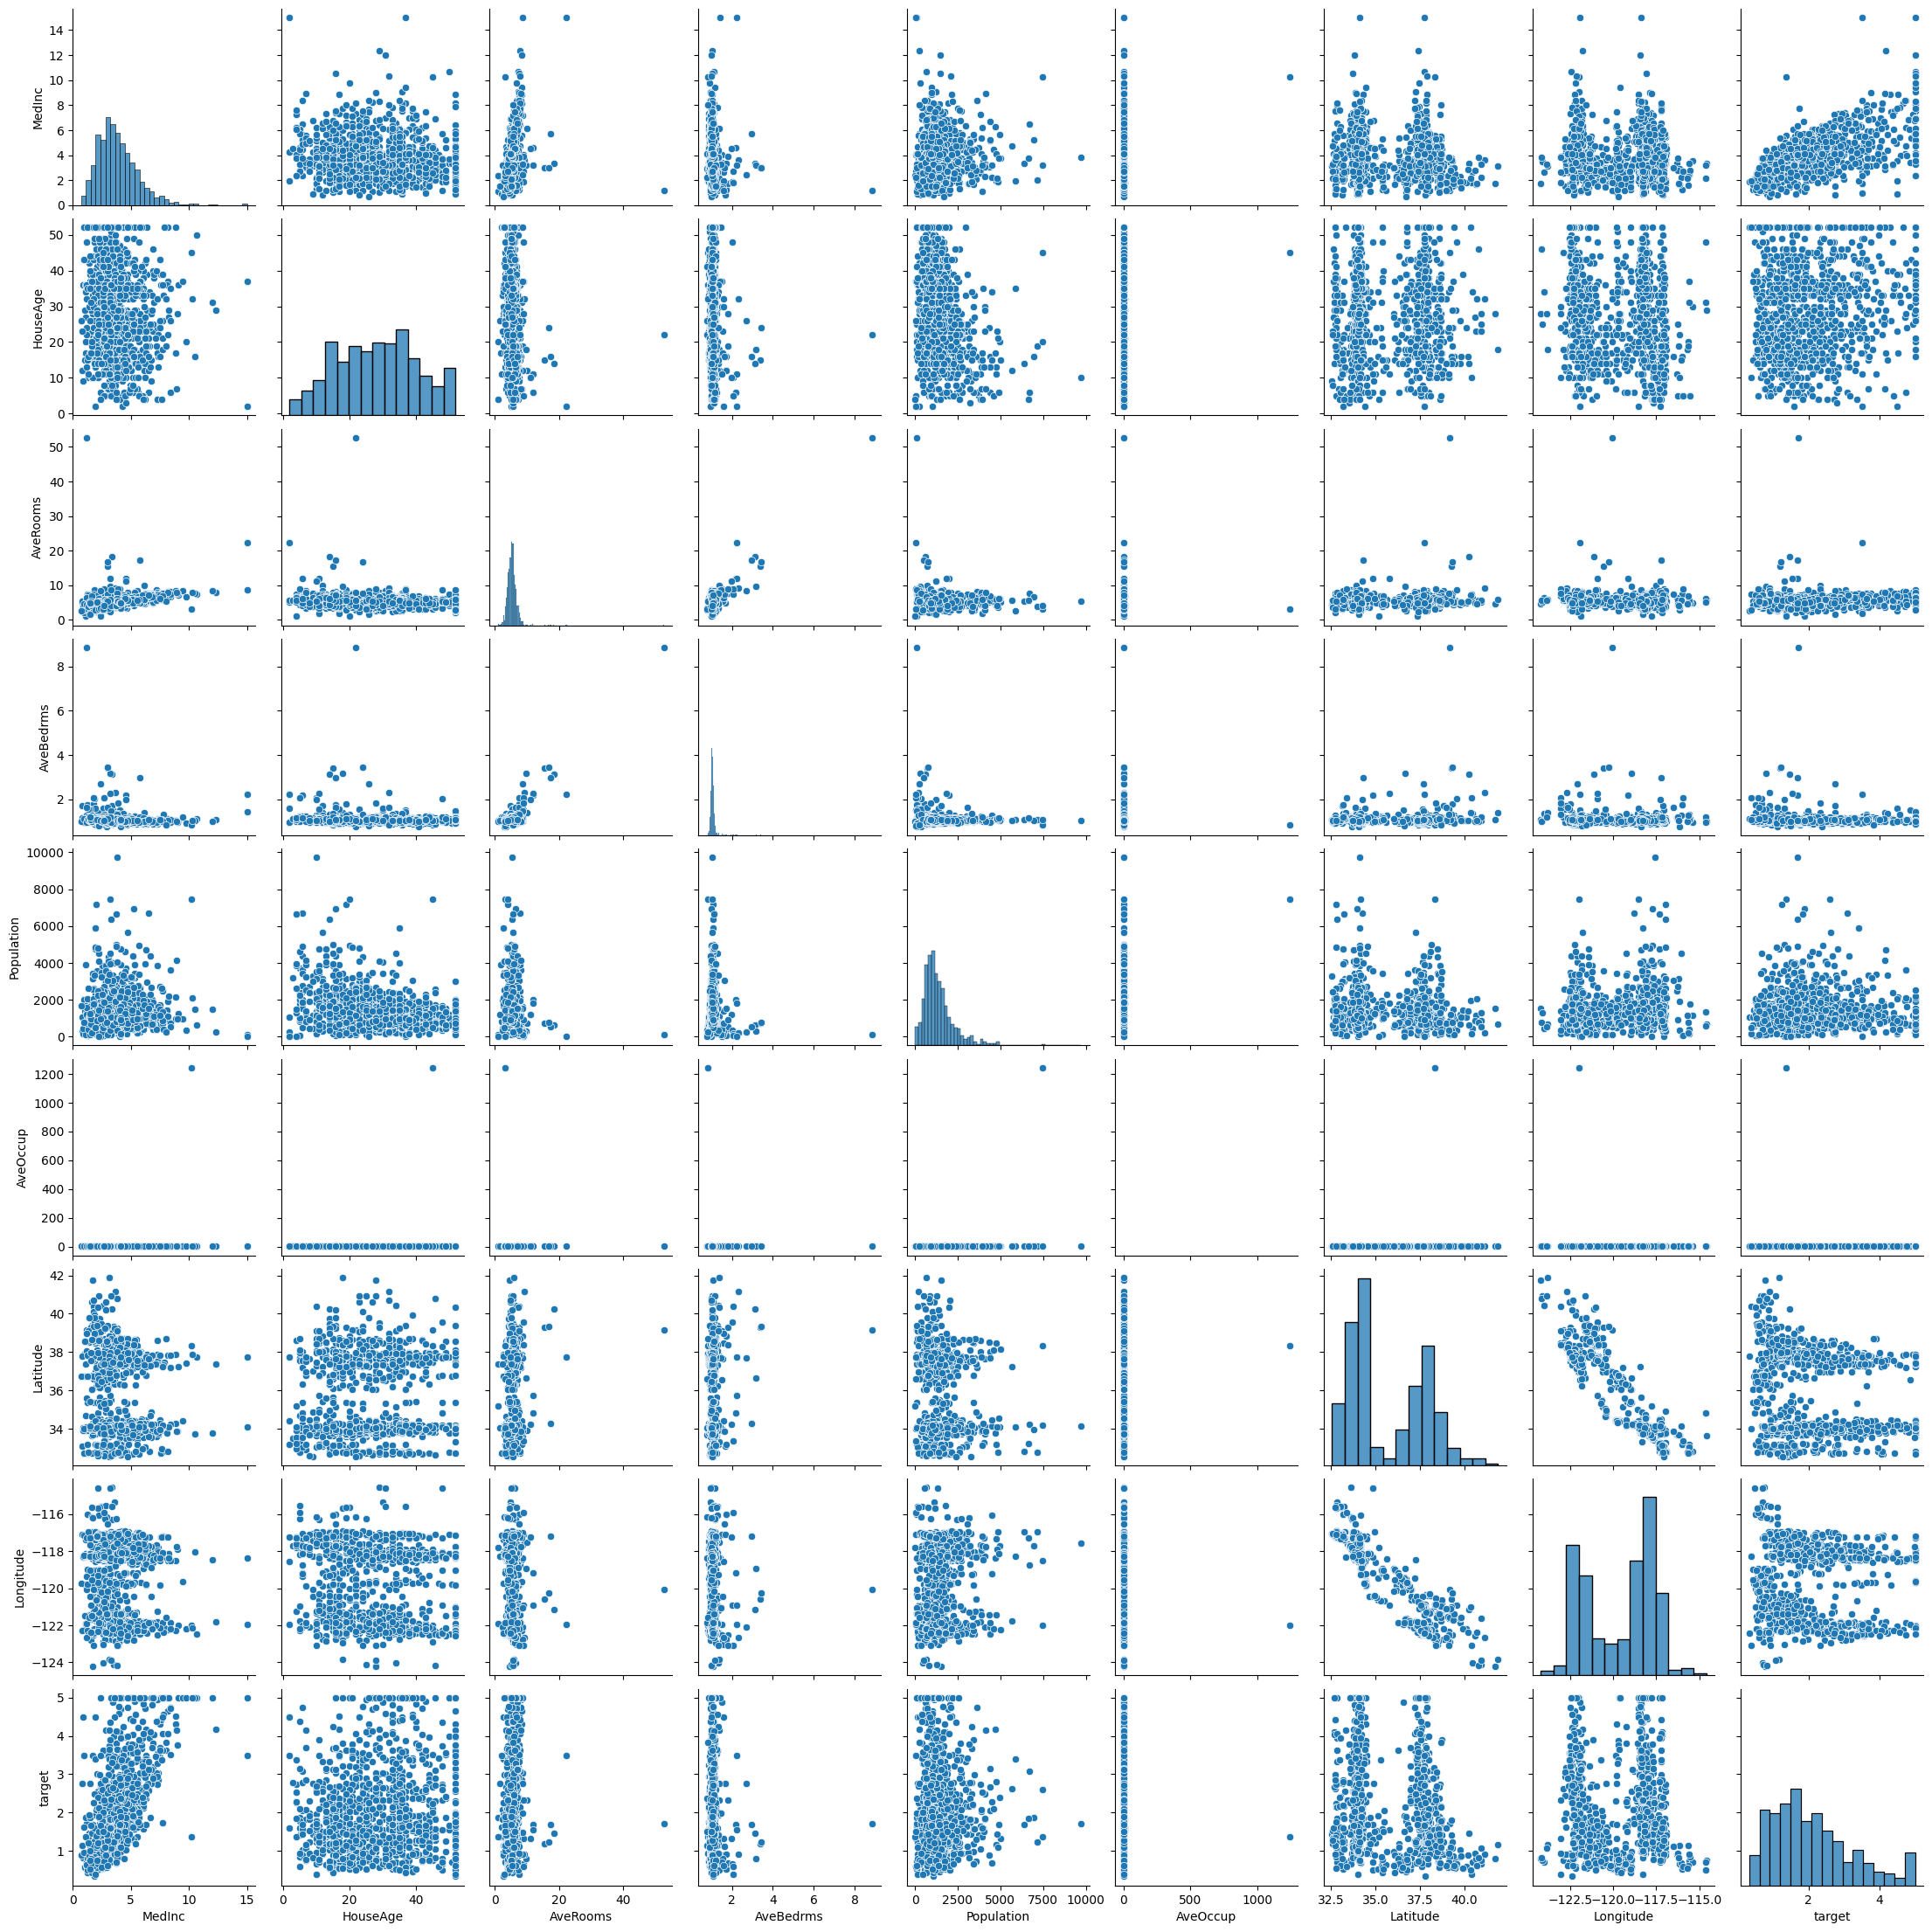

In [24]:
sns.pairplot(housing_data)

C:\Users\butlerju\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


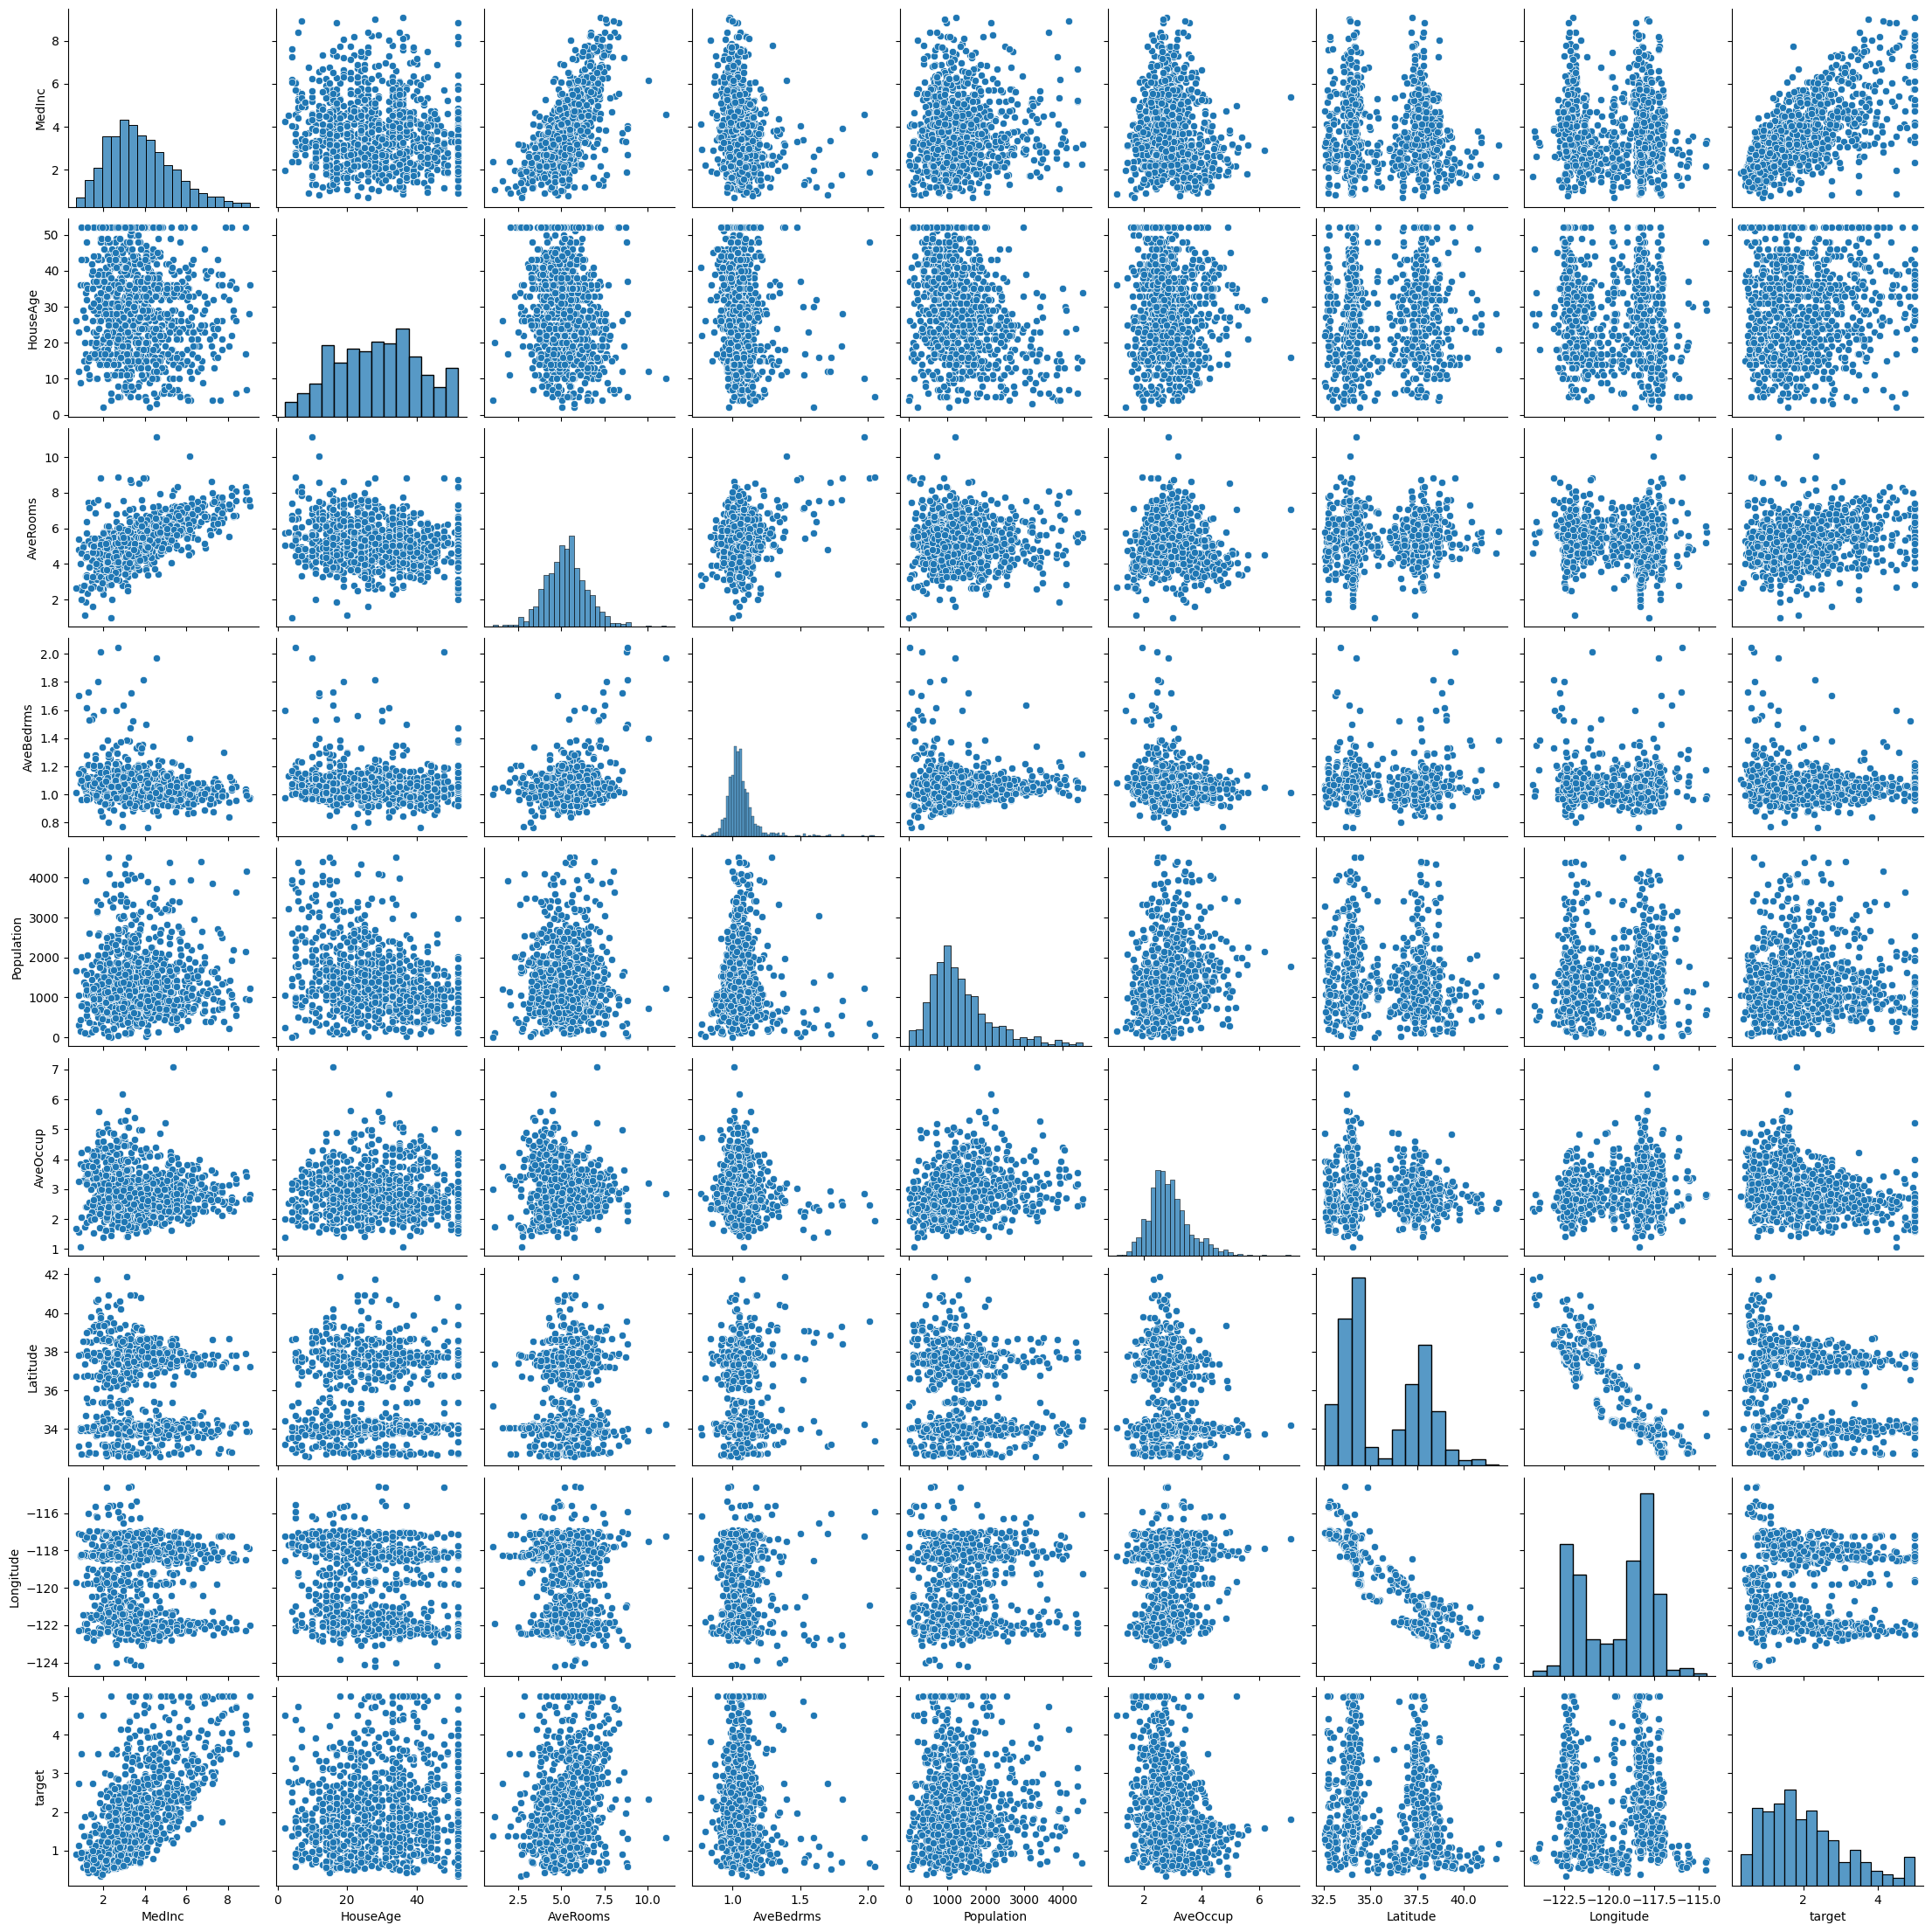

In [25]:
# Remove outliers from the data set and make the pairplot again

from scipy import stats

housing_data = housing_data[(np.abs(stats.zscore(housing_data)) < 3).all(axis=1)]

sns.pairplot(housing_data)

## Correlation Matrix

* Correlation score = $\sqrt{R2\ Score}$
* Values close to $\pm1$ means that the two feautures are linearly related

In [26]:
correlation_matrix = housing_data.corr()
correlation_matrix

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
MedInc,1.000000,-0.112005,0.631367,-0.224834,0.039017,-0.058359,-0.073645,-0.035493,0.634589
HouseAge,-0.112005,1.000000,-0.187494,-0.141478,-0.345641,-0.031877,-0.006767,-0.072361,0.130204
AveRooms,0.631367,-0.187494,1.000000,0.266857,-0.036939,-0.010092,0.149356,-0.112851,0.228032
AveBedrms,-0.224834,-0.141478,0.266857,1.000000,-0.034818,-0.147259,0.065357,-0.014019,-0.091087
Population,0.039017,-0.345641,-0.036939,-0.034818,1.000000,0.219505,-0.098055,0.088908,-0.001405
AveOccup,-0.058359,-0.031877,-0.010092,-0.147259,0.219505,1.000000,-0.152587,0.168939,-0.280118
Latitude,-0.073645,-0.006767,0.149356,0.065357,-0.098055,-0.152587,1.000000,-0.927224,-0.147919
Longitude,-0.035493,-0.072361,-0.112851,-0.014019,0.088908,0.168939,-0.927224,1.000000,-0.061421
target,0.634589,0.130204,0.228032,-0.091087,-0.001405,-0.280118,-0.147919,-0.061421,1.000000


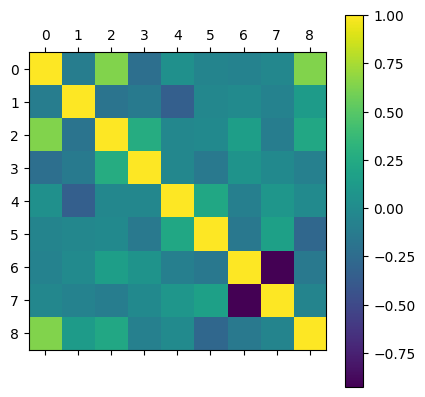

In [27]:
plt.matshow(correlation_matrix)
plt.colorbar()

## LASSO Regression for Feature Selection

In [28]:
X = housing_data.drop(columns=['target'])
y = housing_data['target']
scaler = StandardScaler()
scaler.fit(X)
Z = scaler.transform(X)

In [29]:
lasso = Lasso()
lasso.fit(Z,y)
lasso.coef_

array([ 0.,  0.,  0., -0., -0., -0., -0., -0.])

## Accuracy with All Data (Scaled)

In [30]:
X = housing_data.drop(columns=['target'])
y = housing_data['target']

scaler = StandardScaler()
scaler.fit(X)
Z = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(Z,y,test_size=0.2)

bayesian_ridge = BayesianRidge()
bayesian_ridge.fit(X_train, y_train)
y_pred = bayesian_ridge.predict(X_test)

print('MSE:', MSE(y_pred, y_test))

MSE: 0.41449198151190914


## Accuracy with Most Correlated Features (Scaled)

In [31]:
X_corr = housing_data[['MedInc', 'HouseAge', 'AveRooms']]
y = housing_data['target']

scaler = StandardScaler()
scaler.fit(X_corr)
Z = scaler.transform(X_corr)

X_train, X_test, y_train, y_test = train_test_split(Z,y,test_size=0.2)

bayesian_ridge = BayesianRidge()
bayesian_ridge.fit(X_train, y_train)
y_pred = bayesian_ridge.predict(X_test)

print('MSE:', MSE(y_pred, y_test))

MSE: 0.5499925521765495


## Part 3: Nonlinear Models

## Kernel Ridge Regression (KRR)

* All previous models we have studied have been linear--capable of modeling linear patterns
    * Design matrices can only add some much functions
* Many data sets will have a nonlinear pattern and thus we need a nonlinear model
    * Kernel ridge regression (KRR)
    * Support vector machines (SVMs)
    * Neural Networks

### Kernel Functions
* Scikit-Learn kernels are found [here](https://scikit-learn.org/stable/modules/metrics.html)

    * Linear: $k(x,y) = x^Ty$
    * Polynomial: k(x,y) = $(\gamma x^Ty+c_0)^d$
    * Sigmoid: $k(x,y) = tanh(\gamma x^Ty+c_0)$
    * Radial Basis Function (RBF): $k(x,y) = exp(-\gamma||x-y||_2)$

* Inputs to KRR algorithm are modified by the kernel function, thus giving the method nonlinearuty $\longrightarrow$ kernel methods/trick allows linear methods to solve nonlinear problems
    * Kernel ridge regression is just ridge regression with the inputs modified by the kernel function

### KRR Equations

* Form of predictions: $\hat{y}(x) = \sum_{i=1}^m \theta_ik(x_i,x)$
* Loss function:$J(\theta) = MSE(y,\hat{y}) + \frac{\alpha}{2}\sum_{i=1}^n\theta_i^2$
* Optimized parameters: $\theta = (\textbf{K}-\alpha\textbf{I})y$
    * $\textbf{K} = k(x_i, x_j)$

### Hyperparameter Tuning with Many Hyperparameters
* KRR has the same hyperparameter as ridge regression: $\alpha$
* Each kernel function has 0-3 hyperparameters
* The choice of kernel function is a hyperparameter
* Hyperparameter tuning becomes more important as the number of hyperparameters in the model increases

## Housing Data with Kernel Ridge Regression

In [32]:
X,y = fetch_california_housing(return_X_y=True)

X = X[:500]
y = y[:500]

scaler = StandardScaler()
scaler.fit(X)
Z = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(Z,y,test_size=0.2)

In [34]:
from sklearn.kernel_ridge import KernelRidge

distributions = {'alpha':uniform(loc=0, scale=4), 'kernel':['linear', \
                                                            'polynomial', 'rbf', \
                                                            'sigmoid', 'laplacian'], \
                 'gamma':uniform(loc=0, scale=4),\
                'degree':np.arange(0,10), 'coef0':uniform(loc=0, scale=4)}

krr = KernelRidge()

random_search = RandomizedSearchCV(krr, distributions,\
                                   scoring='neg_mean_squared_error', n_iter=50)
random_search.fit(X_train, y_train)
print(random_search)
print(random_search.best_params_, random_search.best_score_)

C:\Users\butlerju\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\butlerju\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\butlerju\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\butlerju\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\butlerju\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:250: User

RandomizedSearchCV(estimator=KernelRidge(), n_iter=50,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001CA6D938450>,
                                        'coef0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001CA7C364250>,
                                        'degree': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001CA6D8EEA10>,
                                        'kernel': ['linear', 'polynomial',
                                                   'rbf', 'sigmoid',
                                                   'laplacian']},
                   scoring='neg_mean_squared_error')
{'alpha': 1.4955223273616443, 'coef0': 1.7029743989885442, 'degree': 1, 'gamma': 0.9280980797931906, 'kernel': 'polynomial'} -0.29103091943862835


C:\Users\butlerju\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [-1.51721690e+07 -4.15652260e+00 -1.00960953e+03 -3.31163687e+00
 -1.03130897e+08 -6.71115254e+02 -4.64677940e-01             nan
 -4.61585069e+00 -1.34678120e+00 -2.91030919e-01 -2.30785649e+00
 -4.63030021e+00 -3.98732436e+00 -1.43804240e+02 -3.98452064e+00
 -3.45865151e+02 -3.98595913e+00 -3.44015256e+00 -1.46058671e+04
 -3.98668292e+00 -3.21855091e+05 -3.98975635e+00 -3.98632376e+00
 -4.63413319e+00 -6.29402745e-01 -3.99001721e+00 -3.95902555e+00
 -5.03797485e+01 -3.98608535e+00 -4.52769774e+00 -4.04546493e+04
 -3.02002590e+01 -4.58858571e+00 -3.98515048e+00 -3.98596526e+00
 -3.36088050e+00 -2.82397908e+02 -9.88420559e-01 -4.62942507e+00
 -3.98659441e+00 -1.93220687e+05 -4.28575107e+00 -3.98949651e+00
 -4.17559394e+03 -3.08064424e+02 -3.69365561e-01 -2.09419734e+00
 -6.13225089e+02 -3.98685439e+00]
  warnings

In [35]:
X,y = fetch_california_housing(return_X_y=True)

scaler = StandardScaler()
scaler.fit(X)
Z = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(Z,y,test_size=0.2)

In [39]:
# Using the best parameters from through one run of the 
# RandomizedSearchCV method above
krr = KernelRidge(alpha= 0.35753693232459094, coef0= 3.2725118241858264, degree= 9, gamma= 0.14696609545731532, kernel= 'laplacian')
krr.fit(X_train, y_train)
y_pred = krr.predict(X_test)
print('MSE:', MSE(y_pred, y_test))

MSE: 0.23606179582135453


In [40]:
bayesian_ridge = BayesianRidge()
bayesian_ridge.fit(X_train, y_train)
y_pred = bayesian_ridge.predict(X_test)
print('MSE:', MSE(y_pred, y_test))

MSE: 0.531538172246382
